In [93]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml
import scanpy as sc

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations
from pathlib import Path
from adjustText import adjust_text


# Utility functions 

In [94]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, channel=None, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        if channel == None:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,channel],"grey")
        plt.axis("off")
        plt.grid("off")
        plt.show()
        if i == n_to_plot:
            break

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.ones(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,1)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

# Import models

In [95]:
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp_all.csv", index_col=0)

bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv",
                           index_col=0)

In [96]:
drug2y = dict(zip(bbbc021_index.CPD_NAME, bbbc021_index.ANNOT))

Get ood drugs 

In [97]:
ood_drugs = ["taxol", 
             "ALLN", 
             "bryostatin", 
             "simvastatin", 
             "MG-132", 
             "methotrexate", 
             "colchicine", 
             "cytochalasin B", 
             "AZ258", 
             "cisplatin"]

In [98]:
ood_drug_embeddings = bbbbc021_embeddings.loc[ood_drugs]

In [99]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

with open(path_to_configs / 'REBUTTAL_bbbc021_large_all.yaml', 'r') as IMPA_bbbc021:
    # Load YAML data using safe_load() from the file
    yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)

yaml_IMPA_bbbc021["z_dimension"] = 8
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240902_fc588378-f1f0-4cfb-84f5-92ed48f31a44_bbbc021_unannotated_large"

args = OmegaConf.create(yaml_IMPA_bbbc021)
dataloader = CellDataLoader(args)
IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

IMPA_bbbc021._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 16164480
Number of parameters in discriminator: 14341784
Number of parameters in mapping_network: 66112
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(88, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

# Check embeddings

In [8]:
learnt_embs = []
drug_labs = []

In [9]:
for emb in bbbbc021_embeddings.index:
    learnt_embs.append(torch.tensor(bbbbc021_embeddings.loc[emb]))
    drug_labs.append(emb)

In [10]:
learnt_embs = torch.stack(learnt_embs, dim=0).cuda()

In [11]:
with torch.no_grad():
    z = torch.randn(1, 100, args.z_dimension).cuda().mean(1)
    z = z.repeat((learnt_embs.shape[0], 1)).cuda()
    y_emb = torch.cat([learnt_embs, z], dim=1)
    y_emb = IMPA_bbbc021.nets.mapping_network(y_emb).cpu()

In [12]:
obs = pd.DataFrame({"Drug name": drug_labs, 
       "State": ["Unseen" if drug in ood_drugs else "Seen" for drug in drug_labs]
      })

In [13]:
adata = sc.AnnData(X=y_emb.numpy(), 
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
sc.tl.pca(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


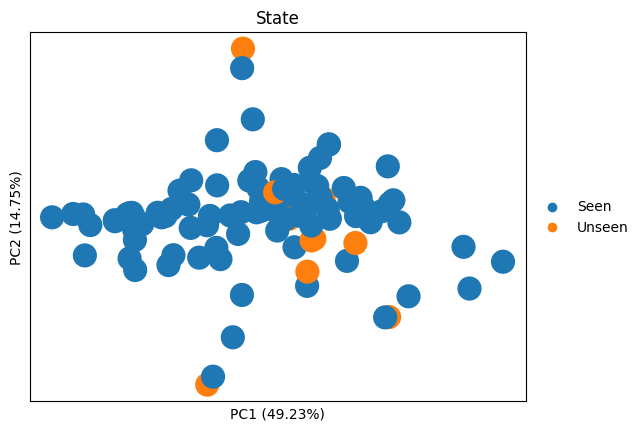

In [15]:
sc.pl.pca(adata, color="State", annotate_var_explained=True)

In [16]:
sc.pp.neighbors(adata)

In [17]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


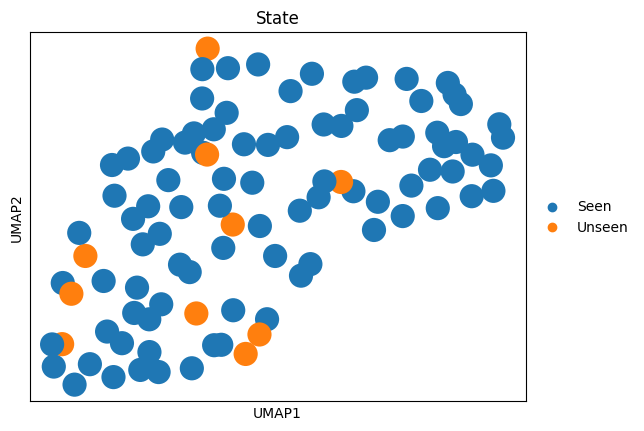

In [18]:
sc.pl.umap(adata, color="State")

## Annotate the plot

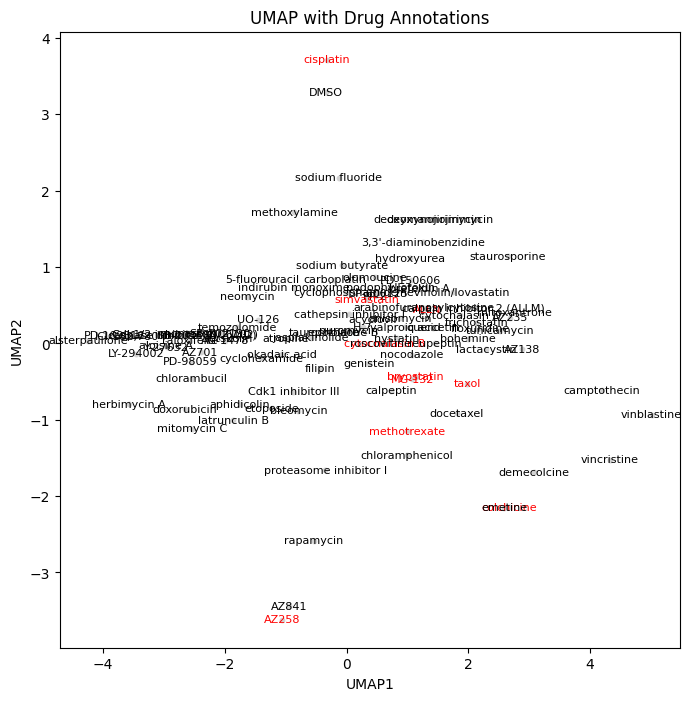

In [19]:
umap_coords = adata.obsm['X_pca']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'drug_names' with your column name

# Create the UMAP plot
plt.figure(figsize=(8, 8))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate the UMAP with drug names
for i, name in enumerate(annotation_names):
    col = "black" if name not in ood_drugs else "red"
    plt.text(umap_coords[i, 0], umap_coords[i, 1], name, fontsize=8, ha='center', va='center', color=col)

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Annotations')

# Show the plot
plt.show()

## Get one real image per drug 

In [55]:
folder = Path("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large")

In [56]:
leavout_plates = {
         "DMSO": ["Week1_22401"],
         "PD-150606": ["Week9_39301"],
         "cathepsin inhibitor I":["Week9_39221"],
         "colchicine": ["Week1_22401","Week1_22123"],
         "cytochalasin B": ["Week1_22161","Week1_22123"],
         "doxorubicin": ["Week1_22361"],
         "epothilone B": ["Week1_22361"],
         "latrunculin B": ["Week1_22381","Week1_22401"], 
         "nocodazole": ["Week1_22123","Week1_22381"]}

In [57]:
idxs = []
drug2image = {}
drug2week = {}

for drug in np.unique(bbbc021_index.CPD_NAME):
    bbbc021_index_loc = bbbc021_index.loc[bbbc021_index.CPD_NAME==drug]
    batch  = np.array(bbbc021_index_loc.BATCH)
    if drug in leavout_plates:
        bbbc021_index_loc = bbbc021_index.loc[~bbbc021_index.BATCH.isin(leavout_plates[drug])]
    # Choose random obs 
    m = 0
    v = 0
    while m < 20 or v < 200:
        choice = np.random.choice(list(bbbc021_index_loc.index))
        filename = bbbc021_index.loc[choice].SAMPLE_KEY
        filename_split = filename.split("_")
        file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
        m = file.mean()
        v = file.var()
    
    drug2image[drug] = file
    drug2week[drug] = bbbc021_index_loc.loc[choice].BATCH
    
# bbbc021_index_no_dup = bbbc021_index.loc[idxs]
# bbbc021_index_no_dup = bbbc021_index.loc[bbbc021_index.CPD_NAME=="taxol"]
# file2drug = list(zip(bbbc021_index_no_dup.SAMPLE_KEY, bbbc021_index_no_dup.ANNOT))
# drug2week = dict(zip(bbbc021_index_no_dup.ANNOT, bbbc021_index_no_dup.BATCH))

In [58]:
# for filename, drug in file2drug:
#     filename_split = filename.split("_")
#     file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
#     drug2image[drug] = file

3,3'-diaminobenzidine
Week8_38203
88.7891845703125
1241.0174465030432


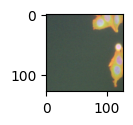

5-fluorouracil
Week4_27481
99.61627197265625
2787.6539612971246


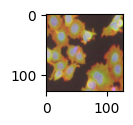

AG-1478
Week4_27542
89.10408528645833
3012.889801018768


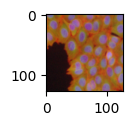

ALLN
Week2_24121
108.12514241536458
3312.840357442283


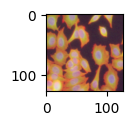

AZ138
Week10_40119
26.472493489583332
2383.18133160803


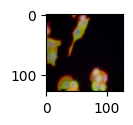

AZ235
Week9_39206
73.97265625
3336.7833506266275


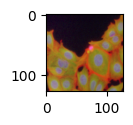

AZ258
Week4_27821
114.5927734375
2318.449034690857


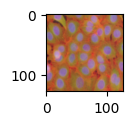

AZ701
Week5_28961
37.253336588541664
472.25409856769784


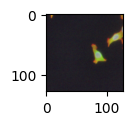

AZ841
Week3_25421
114.89691162109375
2363.9904510738947


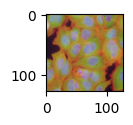

Cdk1 inhibitor III
Week8_38221
49.905721028645836
1977.7818829599353


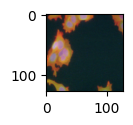

Cdk1/2 inhibitor (NU6102)
Week10_40119
65.92256673177083
2246.02582375043


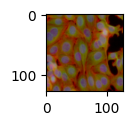

DMSO
Week9_39222
69.41798909505208
761.4132774666781


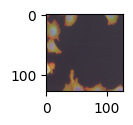

H-7
Week9_39222
71.50791422526042
2408.3179305291014


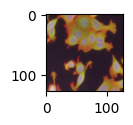

ICI-182,780
Week5_29301
80.51906331380208
2509.8509142593375


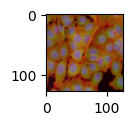

LY-294002
Week5_28961
55.0213623046875
1784.7974765946467


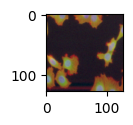

MG-132
Week2_24401
70.34877522786458
4070.719155807876


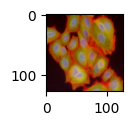

PD-150606
Week1_22141
46.828633626302086
3418.0476395881


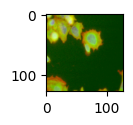

PD-169316
Week7_34681
112.50168863932292
1588.764116614643


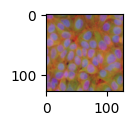

PD-98059
Week3_25701
96.02825927734375
2619.8033395968378


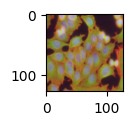

PP-2
Week8_38341
111.83089192708333
2431.3623529805077


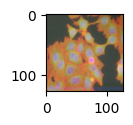

SB-202190
Week5_28901
112.18597412109375
2870.385071015606


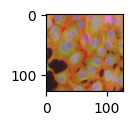

SB-203580
Week5_29301
68.19175211588542
2255.4999539450637


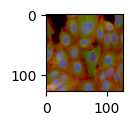

SP-600125
Week6_31661
86.45161946614583
2503.100890118215


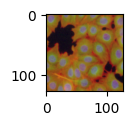

UO-126
Week3_25461
102.73028564453125
2459.4133991859853


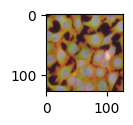

Y-27632
Week3_25701
89.42718505859375
2448.5549193384745


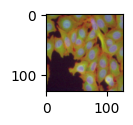

acyclovir
Week6_32121
48.5771484375
2800.5533742904663


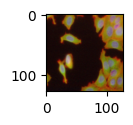

aloisine A
Week5_29301
50.407246907552086
2030.491803764883


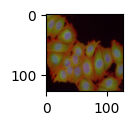

alsterpaullone
Week7_34661
69.59004720052083
2159.701201397512


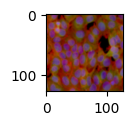

anisomycin
Week4_27481
32.127950032552086
1835.120164433701


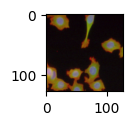

aphidicolin
Week1_22161
137.9615681966146
3275.1391683415404


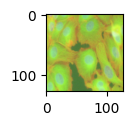

arabinofuranosylcytosine
Week7_34641
112.24936930338542
1567.465423186206


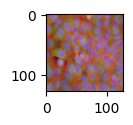

atropine
Week6_32061
27.744242350260418
2112.79699443736


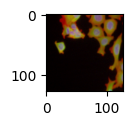

bleomycin
Week6_31661
58.9759521484375
2268.6664138883352


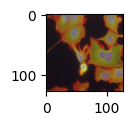

bohemine
Week8_38342
69.19807942708333
3789.4793599181708


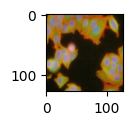

brefeldin A
Week2_24401
67.97806803385417
3030.7275056425074


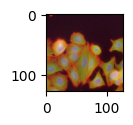

bryostatin
Week7_34661
45.576395670572914
2486.2326077119346


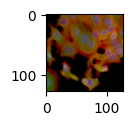

calpain inhibitor 2 (ALLM)
Week6_32061
79.81353759765625
2770.417766766002


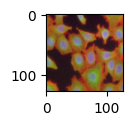

calpeptin
Week8_38342
51.474019368489586
2133.4059412177235


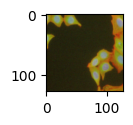

camptothecin
Week8_38221
23.039306640625
1478.0052909255028


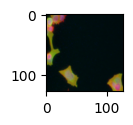

carboplatin
Week9_39282
42.259541829427086
813.5667729671628


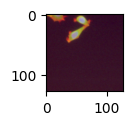

caspase inhibitor 1 (ZVAD)
Week4_27861
82.33709716796875
2952.6232429407537


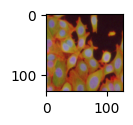

cathepsin inhibitor I
Week4_27821
96.04954020182292
2841.302009472831


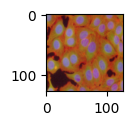

chlorambucil
Week3_25701
92.8111572265625
2414.3764884720244


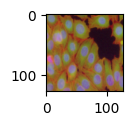

chloramphenicol
Week7_34681
47.899434407552086
1268.1109192764593


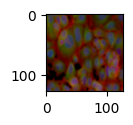

cisplatin
Week3_25681
95.33638509114583
2023.1212200704547


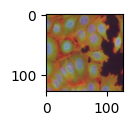

colchicine
Week9_39283
49.10888671875
1798.8034919897716


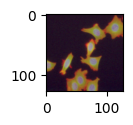

cyclohexamide
Week4_27801
36.356709798177086
2407.6867433086863


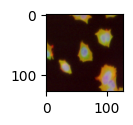

cyclophosphamide
Week8_38342
75.3046875
2733.7319539388022


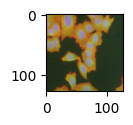

cytochalasin B
Week8_38221
31.08636474609375
1341.5078202647467


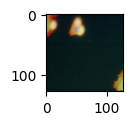

cytochalasin D
Week2_24141
51.17138671875
4559.068038702011


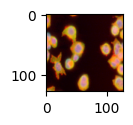

demecolcine
Week3_25721
62.54058837890625
1993.2793177527685


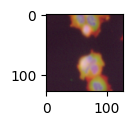

deoxymannojirimycin
Week7_34681
43.556722005208336
1017.2865775360001


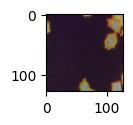

deoxynojirimycin
Week9_39283
72.10870361328125
2942.9564248981574


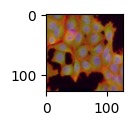

docetaxel
Week7_34381
66.335205078125
2633.9331697821617


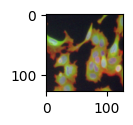

doxorubicin
Week4_27861
28.069905598958332
2355.1291057202548


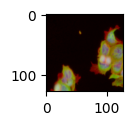

emetine
Week3_25721
25.35382080078125
2313.3503764333823


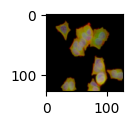

epothilone B
Week2_24141
32.536844889322914
1049.733261594756


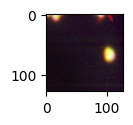

etoposide
Week3_25421
83.79018147786458
2774.8228178218837


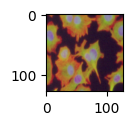

filipin
Week8_38341
79.01961263020833
2212.024883899424


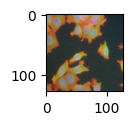

floxuridine
Week9_39301
73.72416178385417
2460.6115353488262


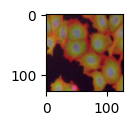

forskolin
Week7_34641
128.352294921875
1724.3157483140628


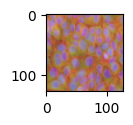

genistein
Week2_24161
114.82570393880208
3199.7350220874782


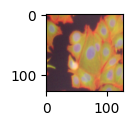

herbimycin A
Week2_24401
39.363810221354164
2631.046149609818


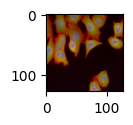

hydroxyurea
Week6_31681
79.60166422526042
2371.4110104139477


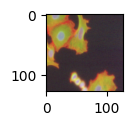

indirubin monoxime
Week4_27481
92.96844482421875
2606.746949420621


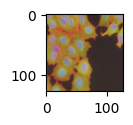

jasplakinolide
Week2_24401
36.087809244791664
1876.9488731953836


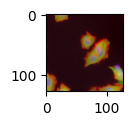

lactacystin
Week6_31641
69.00413004557292
2797.1002637044426


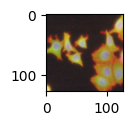

latrunculin B
Week6_32061
83.89774576822917
2716.195883590314


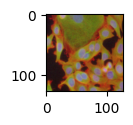

leupeptin
Week8_38203
31.4881591796875
1310.8605775684118


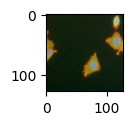

methotrexate
Week2_24121
47.170654296875
750.8435984651247


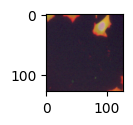

methoxylamine
Week5_29301
40.2403564453125
1953.0041184276342


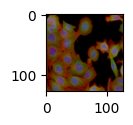

mevinolin/lovastatin
Week9_39222
51.6905517578125
2473.542425379157


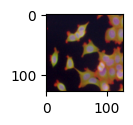

mitomycin C
Week4_27801
76.04044596354167
3027.9663410120543


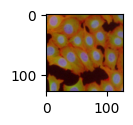

mitoxantrone
Week9_39283
34.93609619140625
2382.360804812362


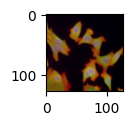

monastrol
Week10_40115
126.57161458333333
2470.0484195285376


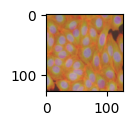

neomycin
Week4_27861
54.625630696614586
2806.384851693693


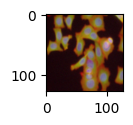

nocodazole
Week8_38342
74.22639973958333
1574.7048059834372


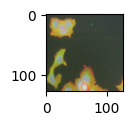

nystatin
Week8_38241
80.40372721354167
2661.593718204234


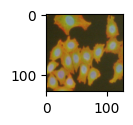

okadaic acid
Week4_27821
86.48610432942708
2766.5981548921104


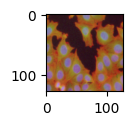

olomoucine
Week4_27481
96.39695231119792
2796.197104155604


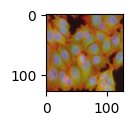

podophyllotoxin
Week6_32061
33.446818033854164
2028.5224402331644


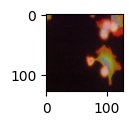

proteasome inhibitor I
Week7_34341
72.46284993489583
2459.415408609642


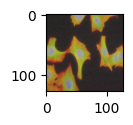

puromycin
Week7_34341
86.41923014322917
3018.1735706312793


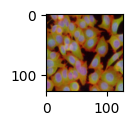

quercetin
Week8_38241
102.05902099609375
3326.489375408739


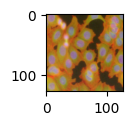

raloxifene
Week5_28921
75.26273600260417
2785.6596888684567


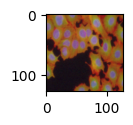

rapamycin
Week2_24141
41.173055013020836
2286.424804566635


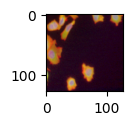

roscovitine
Week2_24381
26.931355794270832
667.3004230641658


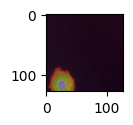

simvastatin
Week9_39283
90.48343912760417
3028.8494978729227


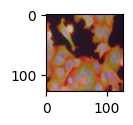

sodium butyrate
Week6_32121
66.49318440755208
2615.4268741206165


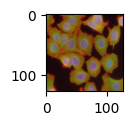

sodium fluoride
Week6_31681
71.33310953776042
2279.0591837064258


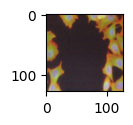

staurosporine
Week3_25421
28.280619303385418
1624.4442630604735


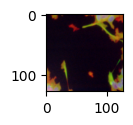

taurocholate
Week6_32121
69.115966796875
3118.03330463171


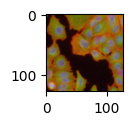

taxol
Week6_31641
23.233133951822918
783.2352196868096


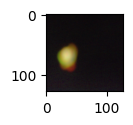

temozolomide
Week10_40119
76.500244140625
2161.9553222060204


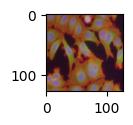

trichostatin
Week6_31681
21.842244466145832
1459.991389233205


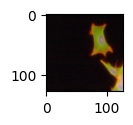

tunicamycin
Week4_27521
74.819091796875
3621.1507845918336


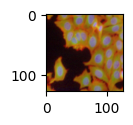

valproic acid
Week7_34681
64.43813069661458
2569.846351225757


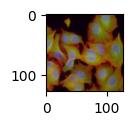

vinblastine
Week2_24161
24.210123697916668
2657.7782764169906


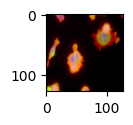

vincristine
Week3_25441
47.568705240885414
1277.3326412435208


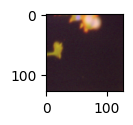

In [59]:
for drug in drug2image:
    print(drug)
    print(drug2week[drug])
    print(drug2image[drug].mean())
    print(drug2image[drug].var())
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Transform images 

In [25]:
drugs = {}
controls = {}

for drug in ood_drugs:
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    control, transformed = transform_by_emb(IMPA_bbbc021, dataloader, emb_drug, 100, args)
    drugs[drug] = transformed
    controls[drug] = control

  0%|          | 0/593 [00:02<?, ?it/s]


taxol
DMSOs


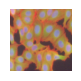

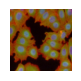

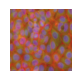

Transformed


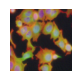

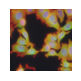

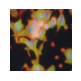

Real


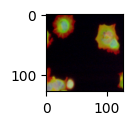

ALLN
DMSOs


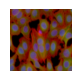

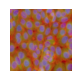

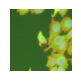

Transformed


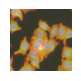

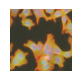

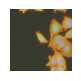

Real


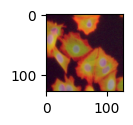

bryostatin
DMSOs


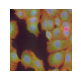

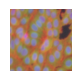

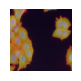

Transformed


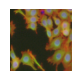

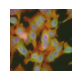

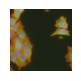

Real


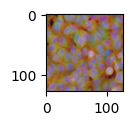

simvastatin
DMSOs


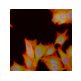

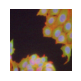

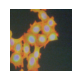

Transformed


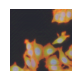

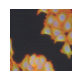

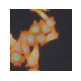

Real


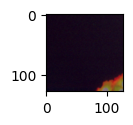

MG-132
DMSOs


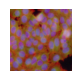

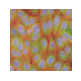

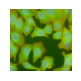

Transformed


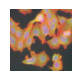

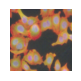

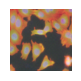

Real


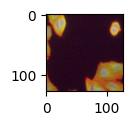

methotrexate
DMSOs


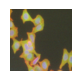

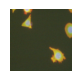

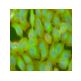

Transformed


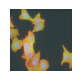

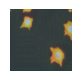

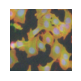

Real


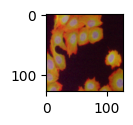

colchicine
DMSOs


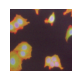

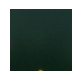

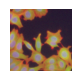

Transformed


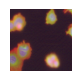

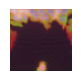

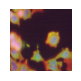

Real


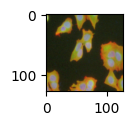

cytochalasin B
DMSOs


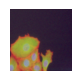

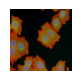

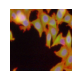

Transformed


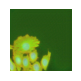

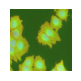

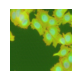

Real


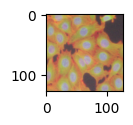

AZ258
DMSOs


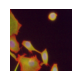

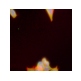

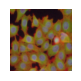

Transformed


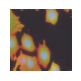

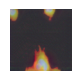

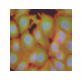

Real


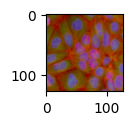

cisplatin
DMSOs


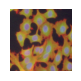

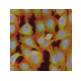

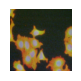

Transformed


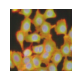

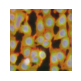

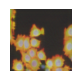

Real


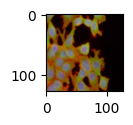

In [26]:
for drug in drugs:
    print(drug)
    print("DMSOs")
    plot_n_images(controls[drug], 2, [0,1,2], (0.8,0.8))
    # plot_n_images(controls[drug], 5, [0,1,2], (0.8,0.8))
    print("Transformed")
    plot_n_images(drugs[drug], 2, [0,1,2], (0.8,0.8))
    print("Real")
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Check phenotypes in the UMAP

In [27]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [28]:
exclude = ["aphidicolin"]

In [29]:
def annotate_images(ax, x, y, img):
    imagebox = OffsetImage(img, zoom=0.15)  # Adjust zoom as necessary
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

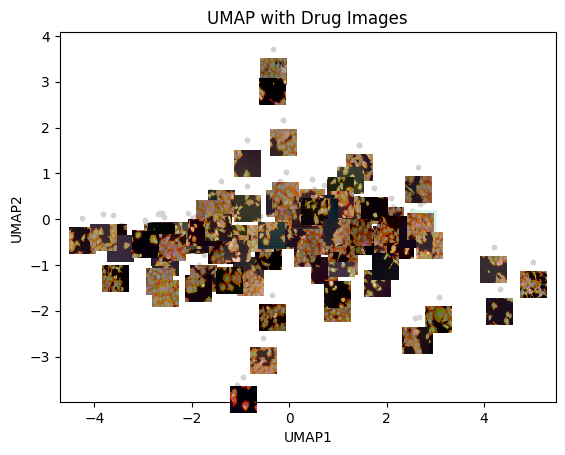

In [30]:
# Create the UMAP plot
fig, ax = plt.subplots()
ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate UMAP with images
for i, drug in enumerate(drug2image.keys()):
    if drug not in exclude:
        annotate_images(ax, umap_coords[i, 0], umap_coords[i, 1] - 0.5, drug2image[drug])
    # plt.imshow(drug2image[drug], extent=(umap_coords[i, 0] - 0.5, umap_coords[i, 0] + 0.5, 
    #                         umap_coords[i, 1] - 0.5, umap_coords[i, 1] + 0.5), aspect='auto')

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Images')

# Show the plot
plt.show()

## Plot drug by choice

Week2_24141


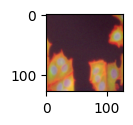

Week2_24141


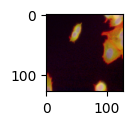

Week2_24141


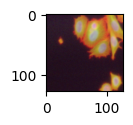

Week2_24141


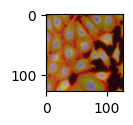

Week2_24121


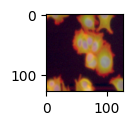

Week2_24161


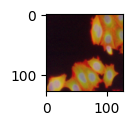

Week2_24141


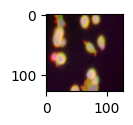

Week2_24121


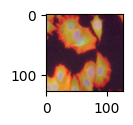

Week2_24121


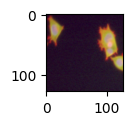

Week2_24141


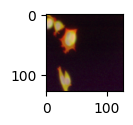

Week2_24161


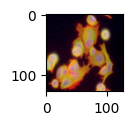

Week2_24141


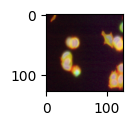

Week2_24121


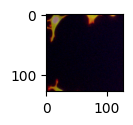

Week2_24161


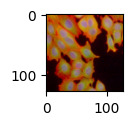

Week2_24121


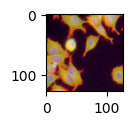

Week2_24141


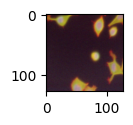

Week2_24161


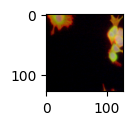

Week2_24141


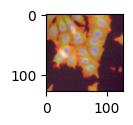

Week2_24141


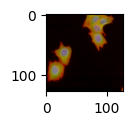

Week2_24141


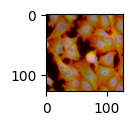

Week2_24121


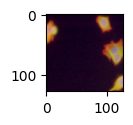

Week2_24141


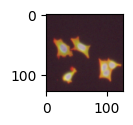

Week2_24121


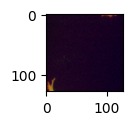

Week2_24121


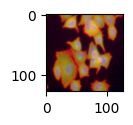

Week2_24141


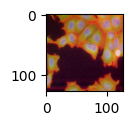

Week2_24141


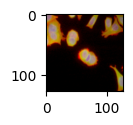

Week2_24121


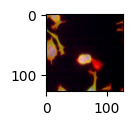

Week2_24141


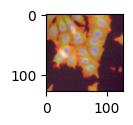

Week2_24161


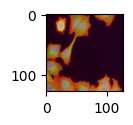

Week2_24161


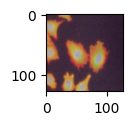

Week2_24141


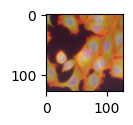

Week2_24141


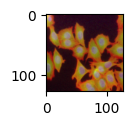

Week2_24121


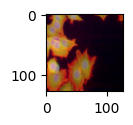

Week2_24161


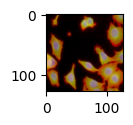

Week2_24161


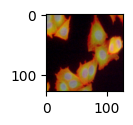

Week2_24121


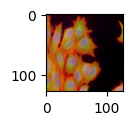

Week2_24141


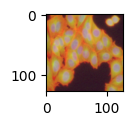

Week2_24161


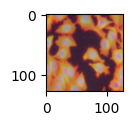

Week2_24121


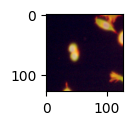

Week2_24121


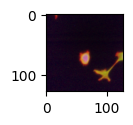

Week2_24161


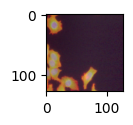

Week2_24161


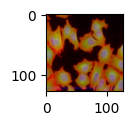

Week2_24161


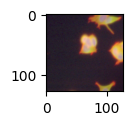

Week2_24161


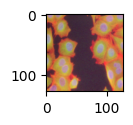

Week2_24121


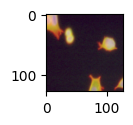

Week2_24141


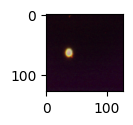

Week2_24161


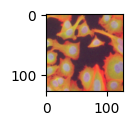

Week2_24161


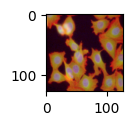

Week2_24121


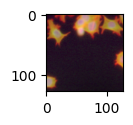

Week2_24141


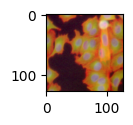

Week2_24141


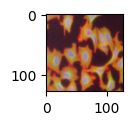

Week2_24121


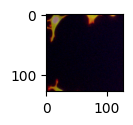

Week2_24141


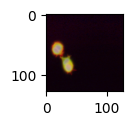

Week2_24121


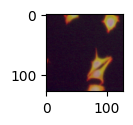

Week2_24121


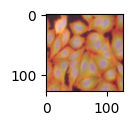

Week2_24121


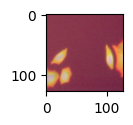

Week2_24141


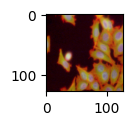

Week2_24161


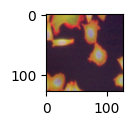

Week2_24141


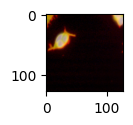

Week2_24161


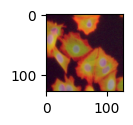

Week2_24161


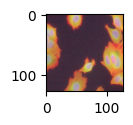

Week2_24141


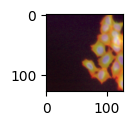

Week2_24161


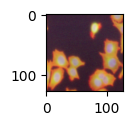

Week2_24121


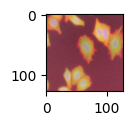

Week2_24161


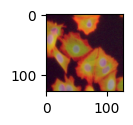

Week2_24161


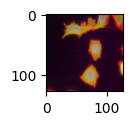

Week2_24141


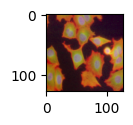

Week2_24121


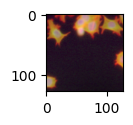

Week2_24161


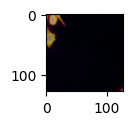

Week2_24121


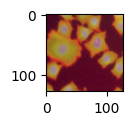

Week2_24121


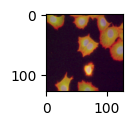

Week2_24141


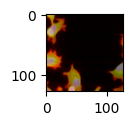

Week2_24161


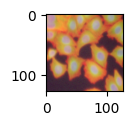

Week2_24141


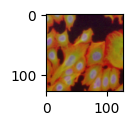

Week2_24141


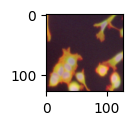

Week2_24161


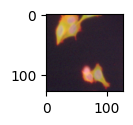

Week2_24141


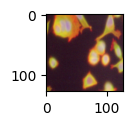

Week2_24141


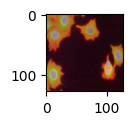

Week2_24141


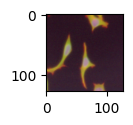

Week2_24161


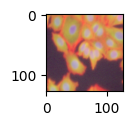

Week2_24161


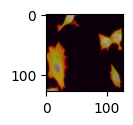

Week2_24121


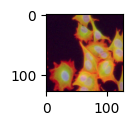

Week2_24161


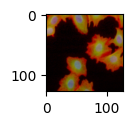

Week2_24161


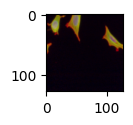

Week2_24121


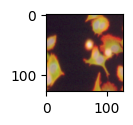

Week2_24161


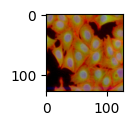

Week2_24121


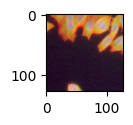

Week2_24161


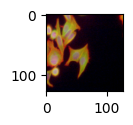

Week2_24121


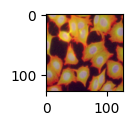

Week2_24141


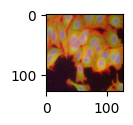

Week2_24121


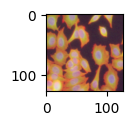

Week2_24121


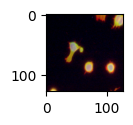

Week2_24161


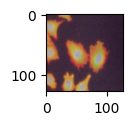

Week2_24161


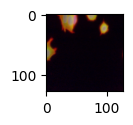

Week2_24121


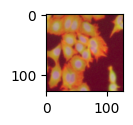

Week2_24121


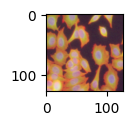

Week2_24141


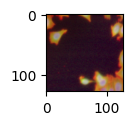

Week2_24141


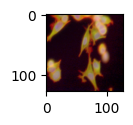

Week2_24141


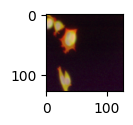

Week2_24161


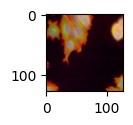

Week2_24161


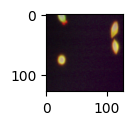

Week2_24121


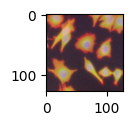

Week2_24141


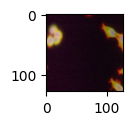

Week2_24161


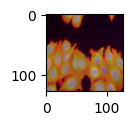

Week2_24141


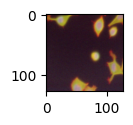

Week2_24161


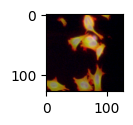

Week2_24161


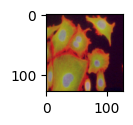

Week2_24121


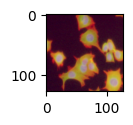

Week2_24141


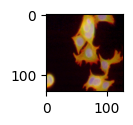

Week2_24141


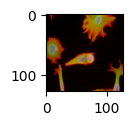

Week2_24121


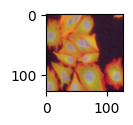

Week2_24161


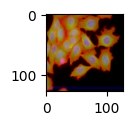

Week2_24121


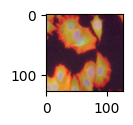

Week2_24141


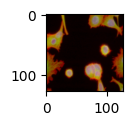

Week2_24121


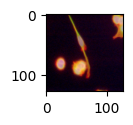

Week2_24161


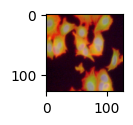

Week2_24141


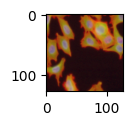

Week2_24161


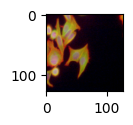

Week2_24141


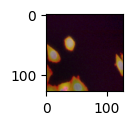

Week2_24161


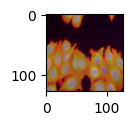

Week2_24121


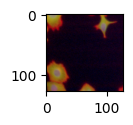

Week2_24141


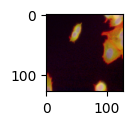

Week2_24161


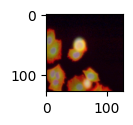

Week2_24141


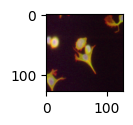

Week2_24121


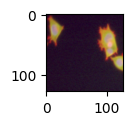

Week2_24161


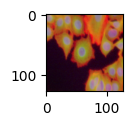

Week2_24161


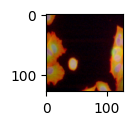

Week2_24141


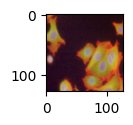

Week2_24141


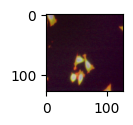

Week2_24121


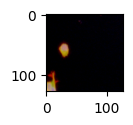

Week2_24141


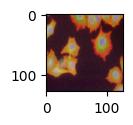

Week2_24141


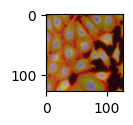

Week2_24141


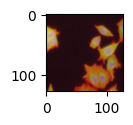

Week2_24161


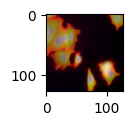

Week2_24121


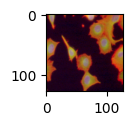

Week2_24121


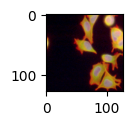

Week2_24141


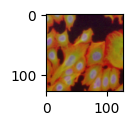

Week2_24141


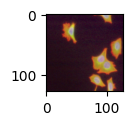

Week2_24141


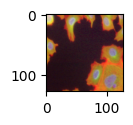

Week2_24161


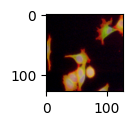

Week2_24121


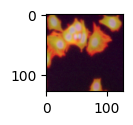

Week2_24141


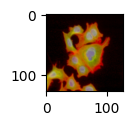

Week2_24161


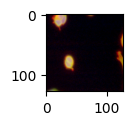

Week2_24161


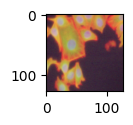

Week2_24141


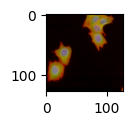

Week2_24141


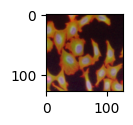

Week2_24161


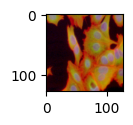

Week2_24141


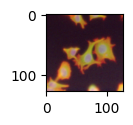

Week2_24121


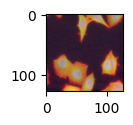

Week2_24121


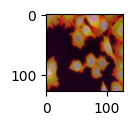

Week2_24161


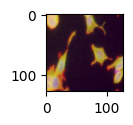

Week2_24121


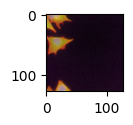

Week2_24161


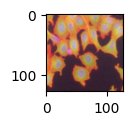

Week2_24161


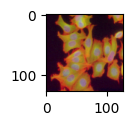

Week2_24161


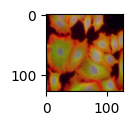

Week2_24121


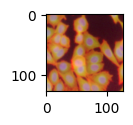

Week2_24141


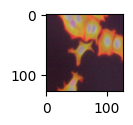

Week2_24161


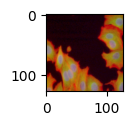

Week2_24121


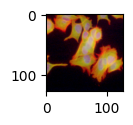

Week2_24141


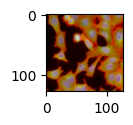

Week2_24141


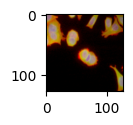

Week2_24141


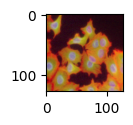

Week2_24121


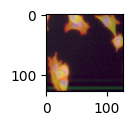

Week2_24161


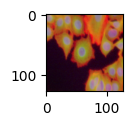

Week2_24141


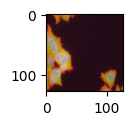

Week2_24161


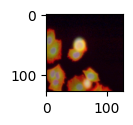

Week2_24141


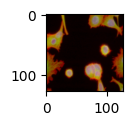

Week2_24121


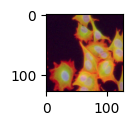

Week2_24141


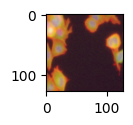

Week2_24161


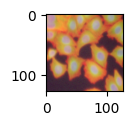

Week2_24121


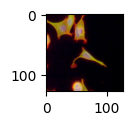

Week2_24141


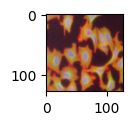

Week2_24121


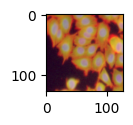

Week2_24161


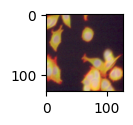

Week2_24121


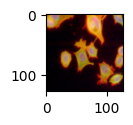

Week2_24121


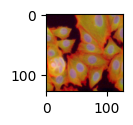

Week2_24161


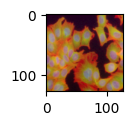

Week2_24141


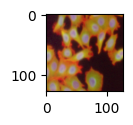

Week2_24121


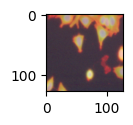

Week2_24141


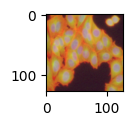

Week2_24161


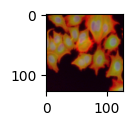

Week2_24121


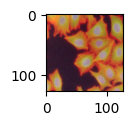

Week2_24121


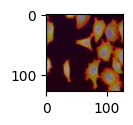

Week2_24121


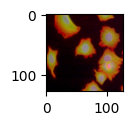

Week2_24161


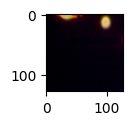

Week2_24161


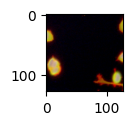

Week2_24141


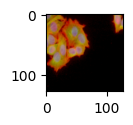

Week2_24161


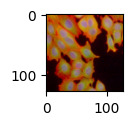

Week2_24161


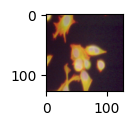

Week2_24121


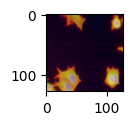

Week2_24141


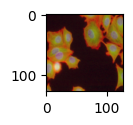

Week2_24141


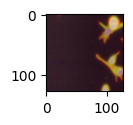

Week2_24141


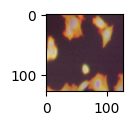

Week2_24141


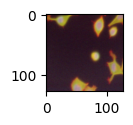

Week2_24141


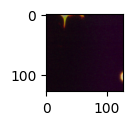

Week2_24161


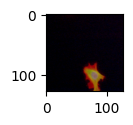

Week2_24161


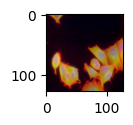

Week2_24121


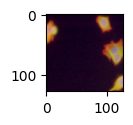

Week2_24121


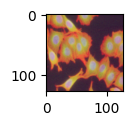

Week2_24121


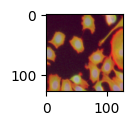

Week2_24121


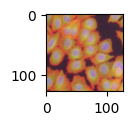

Week2_24161


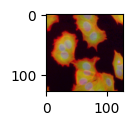

Week2_24161


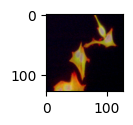

Week2_24141


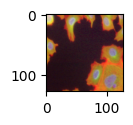

Week2_24141


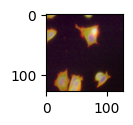

Week2_24161


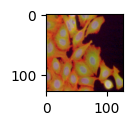

Week2_24121


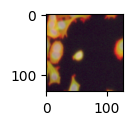

Week2_24121


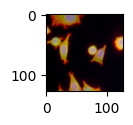

Week2_24121


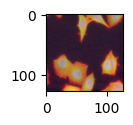

Week2_24141


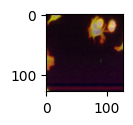

Week2_24141


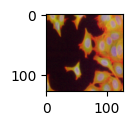

Week2_24121


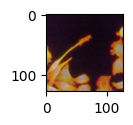

Week2_24161


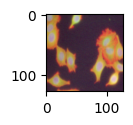

Week2_24121


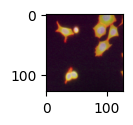

Week2_24161


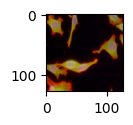

Week2_24121


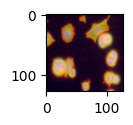

Week2_24141


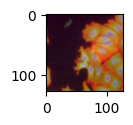

Week2_24161


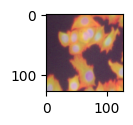

Week2_24121


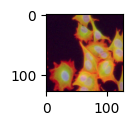

Week2_24161


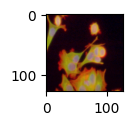

Week2_24141


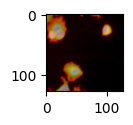

Week2_24121


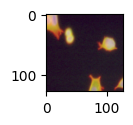

Week2_24141


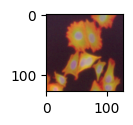

Week2_24161


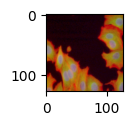

Week2_24121


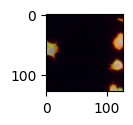

Week2_24121


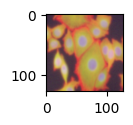

Week2_24121


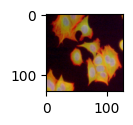

Week2_24141


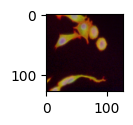

Week2_24121


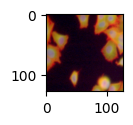

Week2_24141


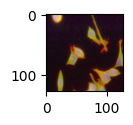

Week2_24141


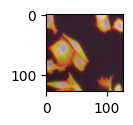

Week2_24161


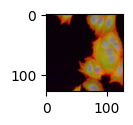

Week2_24161


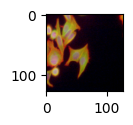

Week2_24141


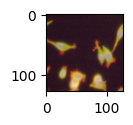

Week2_24161


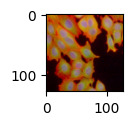

Week2_24121


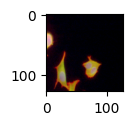

Week2_24121


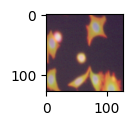

Week2_24161


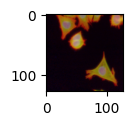

Week2_24121


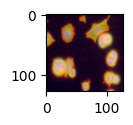

Week2_24121


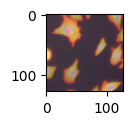

Week2_24141


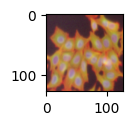

Week2_24141


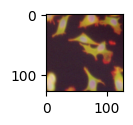

Week2_24141


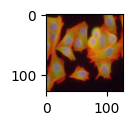

Week2_24121


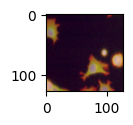

Week2_24121


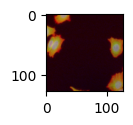

Week2_24161


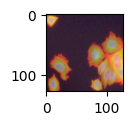

Week2_24141


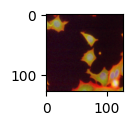

Week2_24121


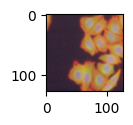

Week2_24161


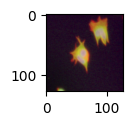

Week2_24141


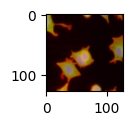

Week2_24121


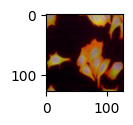

Week2_24161


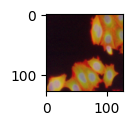

Week2_24161


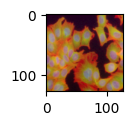

Week2_24121


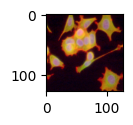

Week2_24121


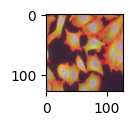

Week2_24141


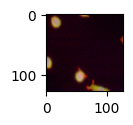

Week2_24141


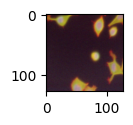

Week2_24141


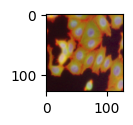

Week2_24121


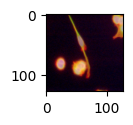

Week2_24121


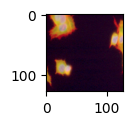

Week2_24161


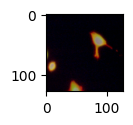

Week2_24161


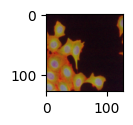

Week2_24161


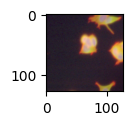

Week2_24141


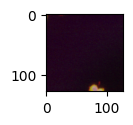

Week2_24141


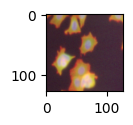

Week2_24141


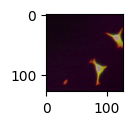

Week2_24141


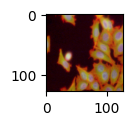

Week2_24141


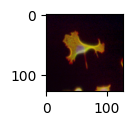

Week2_24121


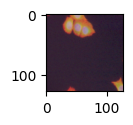

Week2_24161


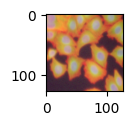

Week2_24121


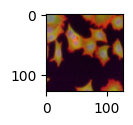

Week2_24141


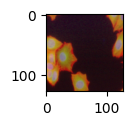

Week2_24141


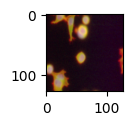

Week2_24121


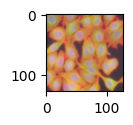

Week2_24141


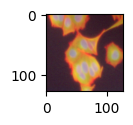

Week2_24141


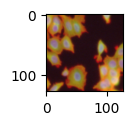

Week2_24141


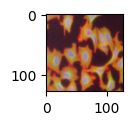

Week2_24161


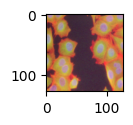

Week2_24161


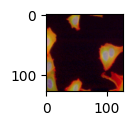

Week2_24121


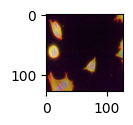

Week2_24161


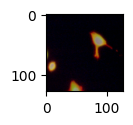

Week2_24141


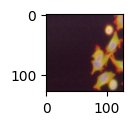

Week2_24121


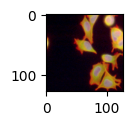

Week2_24161


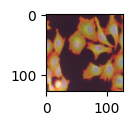

Week2_24121


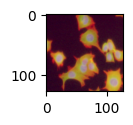

Week2_24161


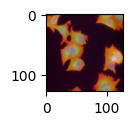

Week2_24141


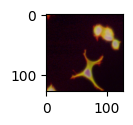

Week2_24141


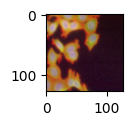

Week2_24161


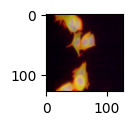

Week2_24161


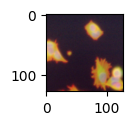

Week2_24141


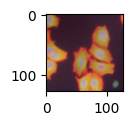

Week2_24161


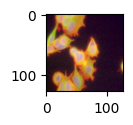

Week2_24161


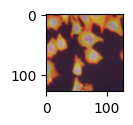

Week2_24141


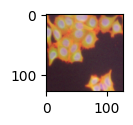

Week2_24141


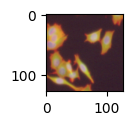

Week2_24161


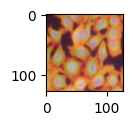

Week2_24161


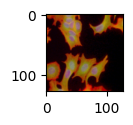

Week2_24161


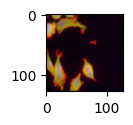

Week2_24141


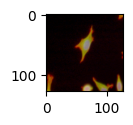

Week2_24161


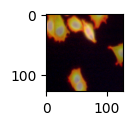

In [84]:
def plot_drug(df, drug, n):
    df_loc = df.loc[df.CPD_NAME==drug]
    if drug in leavout_plates:
        df_loc = df_loc.loc[~df_loc.BATCH.isin(leavout_plates[drug])]
    c = 0
    while c < n:
        choice = np.random.choice(list(df_loc.index))
        print(df_loc.loc[choice].BATCH)
        filename = df_loc.loc[choice].SAMPLE_KEY
        filename_split = filename.split("_")
        file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
        plt.figure(figsize=(1,1))
        plt.imshow(file)
        plt.show()
        c+=1


plot_drug(bbbc021_index, "ALLN", 300)
# print("bryostatin")
# plot_drug(bbbc021_index, "bryostatin",10)

Transformed


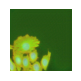

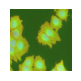

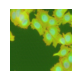

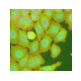

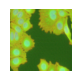

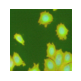

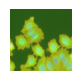

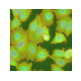

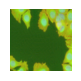

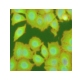

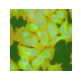

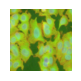

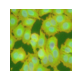

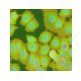

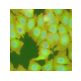

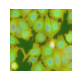

Real


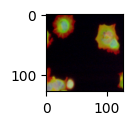

In [33]:
print("Transformed")
plot_n_images(drugs["cytochalasin B"], 100, [0,1,2], (0.8,0.8))
print("Real")
plt.figure(figsize=(1,1))
plt.imshow(drug2image["taxol"])
plt.show()

## Do the plots from before 

In [34]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

In [35]:
metadata_unique = bbbc021_index[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

tanimoto_distance_matrix.loc[ood_drugs]
mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_ood = mat_tani_second_highest_val.loc[ood_drugs]

In [36]:
mat_tani_second_highest_ood.sort_values()

CPD_NAME
cisplatin         0.066667
bryostatin        0.230483
methotrexate      0.239669
cytochalasin B    0.542636
MG-132            0.623762
taxol             0.726316
simvastatin       0.780220
ALLN              0.820513
colchicine        0.845238
AZ258             0.903509
dtype: float64

# Official plot

In [37]:
remove_from_annot = ["emetine", "lactacystin", "MG-132", "anisomycin", "cisplatin", "mitoxantrone", "PP-2", "ALLN"]
# to_annot = [drug for drug in drug2y if (drug2y[drug]!="Unannotated" and drug not in remove_from_annot)] 
# to_annot = [drug for drug in drug2y if (drug2y[drug]!="Unannotated" or "ALLM" in drug) ] 
to_annot = [drug for drug in drug2y] 
# to_annot = [drug for drug in ["bryostatin", "MG-132"]] 

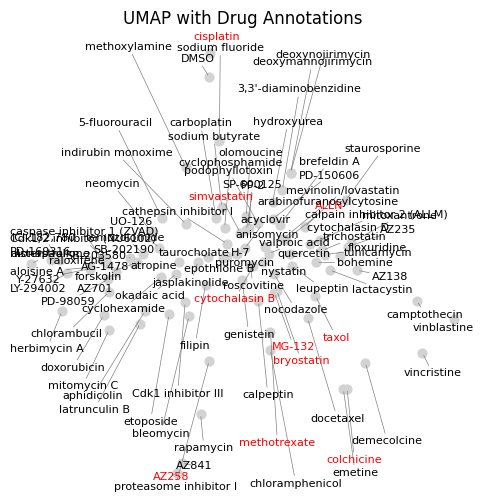

In [38]:
umap_coords = adata.obsm['X_pca']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'Drug name' with your column name

# Create the UMAP plot
plt.figure(figsize=(6,6))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=40, c='lightgray')  # Plot the UMAP points

# List to hold text objects
texts = []

# Annotate the UMAP with drug names
for i, name in enumerate(annotation_names):
    if name in to_annot:
        col = "black" if name not in ood_drugs else "red"
        text = plt.text(umap_coords[i, 0], umap_coords[i, 1], name, fontsize=8, ha='center', va='center', color=col)
        texts.append(text)

# Adjust the positions of the annotations to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

# Remove the axes
plt.axis('off')

# Optionally, you can add a title
plt.title('UMAP with Drug Annotations')

# Show the plot
plt.show()

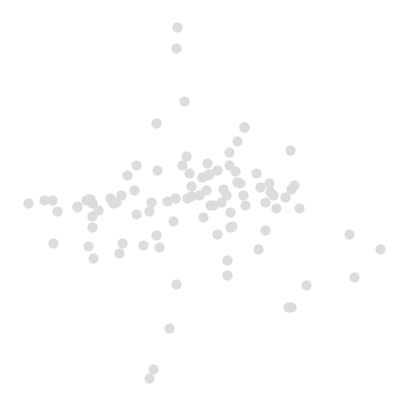

In [39]:
umap_coords = adata.obsm['X_pca']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'Drug name' with your column name

# Create the UMAP plot
plt.figure(figsize=(5,5))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=40, c='gainsboro')  # Plot the UMAP points

# List to hold text objects
texts = []

# Remove the axes
plt.axis('off')

plt.savefig("blank_pca_drugs.svg")
# Show the plot
plt.show()

In [40]:
mol2y = {key:val for key, val in dict(zip(bbbc021_index.CPD_NAME,bbbc021_index.ANNOT)).items() }

In [41]:
mol2y

{'5-fluorouracil': 'Unannotated',
 'acyclovir': 'Unannotated',
 'AG-1478': 'Unannotated',
 'ALLN': 'Protein degradation',
 'aloisine A': 'Unannotated',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'aphidicolin': 'Unannotated',
 'arabinofuranosylcytosine': 'Unannotated',
 'atropine': 'Unannotated',
 'bleomycin': 'Unannotated',
 'bohemine': 'Unannotated',
 'brefeldin A': 'Unannotated',
 'bryostatin': 'Kinase inhibitors',
 'calpain inhibitor 2 (ALLM)': 'Unannotated',
 'calpeptin': 'Unannotated',
 'camptothecin': 'DNA replication',
 'carboplatin': 'Unannotated',
 'caspase inhibitor 1 (ZVAD)': 'Unannotated',
 'cathepsin inhibitor I': 'Unannotated',
 'Cdk1 inhibitor III': 'Unannotated',
 'Cdk1/2 inhibitor (NU6102)': 'Unannotated',
 'chlorambucil': 'DNA damage',
 'chloramphenicol': 'Unannotated',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cyclophosphamide': 'Unannotated',
 'cytochalasin B': '

In [42]:
{'5-fluorouracil': 'Unannotated',
 'acyclovir': 'Unannotated',
 'AG-1478': 'Unannotated',
 'ALLN': 'Protein degradation',
 'aloisine A': 'Unannotated',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'aphidicolin': 'Unannotated',
 'arabinofuranosylcytosine': 'Unannotated',
 'atropine': 'Unannotated',
 'bleomycin': 'Unannotated',
 'bohemine': 'Unannotated',
 'brefeldin A': 'Unannotated',
 'bryostatin': 'Kinase inhibitors',
 'calpain inhibitor 2 (ALLM)': 'Unannotated',
 'calpeptin': 'Unannotated',
 'camptothecin': 'DNA replication',
 'carboplatin': 'Unannotated',
 'caspase inhibitor 1 (ZVAD)': 'Unannotated',
 'cathepsin inhibitor I': 'Unannotated',
 'Cdk1 inhibitor III': 'Unannotated',
 'Cdk1/2 inhibitor (NU6102)': 'Unannotated',
 'chlorambucil': 'DNA damage',
 'chloramphenicol': 'Unannotated',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cyclophosphamide': 'Unannotated',
 'cytochalasin B': 'Actin disruptors',
 'cytochalasin D': 'Actin disruptors',
 'demecolcine': 'Microtubule destabilizers',
 'deoxymannojirimycin': 'Unannotated',
 'deoxynojirimycin': 'Unannotated',
 "3,3'-diaminobenzidine": 'Unannotated',
 'docetaxel': 'Microtubule stabilizers',
 'doxorubicin': 'Unannotated',
 'emetine': 'Protein synthesis',
 'epothilone B': 'Microtubule stabilizers',
 'etoposide': 'DNA damage',
 'filipin': 'Unannotated',
 'floxuridine': 'DNA replication',
 'forskolin': 'Unannotated',
 'genistein': 'Unannotated',
 'H-7': 'Unannotated',
 'herbimycin A': 'Unannotated',
 'hydroxyurea': 'Unannotated',
 'ICI-182,780': 'Unannotated',
 'indirubin monoxime': 'Unannotated',
 'jasplakinolide': 'Unannotated',
 'lactacystin': 'Protein degradation',
 'latrunculin B': 'Actin disruptors',
 'leupeptin': 'Unannotated',
 'LY-294002': 'Unannotated',
 'methotrexate': 'DNA replication',
 'methoxylamine': 'Unannotated',
 'mevinolin/lovastatin': 'Cholesterol-lowering',
 'MG-132': 'Protein degradation',
 'mitomycin C': 'DNA damage',
 'mitoxantrone': 'DNA replication',
 'monastrol': 'Unannotated',
 'neomycin': 'Unannotated',
 'nocodazole': 'Microtubule destabilizers',
 'nystatin': 'Unannotated',
 'okadaic acid': 'Unannotated',
 'olomoucine': 'Unannotated',
 'PD-150606': 'Unannotated',
 'PD-169316': 'Kinase inhibitors',
 'PD-98059': 'Unannotated',
 'podophyllotoxin': 'Unannotated',
 'PP-2': 'Epithelial',
 'proteasome inhibitor I': 'Protein degradation',
 'puromycin': 'Unannotated',
 'quercetin': 'Unannotated',
 'raloxifene': 'Unannotated',
 'rapamycin': 'Unannotated',
 'roscovitine': 'Unannotated',
 'SB-202190': 'Unannotated',
 'SB-203580': 'Unannotated',
 'simvastatin': 'Cholesterol-lowering',
 'sodium butyrate': 'Unannotated',
 'sodium fluoride': 'Unannotated',
 'SP-600125': 'Unannotated',
 'staurosporine': 'Unannotated',
 'taurocholate': 'Unannotated',
 'taxol': 'Microtubule stabilizers',
 'temozolomide': 'Unannotated',
 'trichostatin': 'Unannotated',
 'tunicamycin': 'Unannotated',
 'UO-126': 'Unannotated',
 'valproic acid': 'Unannotated',
 'vinblastine': 'Unannotated',
 'vincristine': 'Microtubule destabilizers',
 'Y-27632': 'Unannotated',
 'AZ235': 'Unannotated',
 'AZ138': 'Eg5 inhibitors',
 'AZ701': 'Unannotated',
 'AZ258': 'Aurora kinase inhibitors',
 'AZ841': 'Aurora kinase inhibitors',
 'DMSO': 'DMSO'}

{'5-fluorouracil': 'Unannotated',
 'acyclovir': 'Unannotated',
 'AG-1478': 'Unannotated',
 'ALLN': 'Protein degradation',
 'aloisine A': 'Unannotated',
 'alsterpaullone': 'Kinase inhibitors',
 'anisomycin': 'Protein synthesis',
 'aphidicolin': 'Unannotated',
 'arabinofuranosylcytosine': 'Unannotated',
 'atropine': 'Unannotated',
 'bleomycin': 'Unannotated',
 'bohemine': 'Unannotated',
 'brefeldin A': 'Unannotated',
 'bryostatin': 'Kinase inhibitors',
 'calpain inhibitor 2 (ALLM)': 'Unannotated',
 'calpeptin': 'Unannotated',
 'camptothecin': 'DNA replication',
 'carboplatin': 'Unannotated',
 'caspase inhibitor 1 (ZVAD)': 'Unannotated',
 'cathepsin inhibitor I': 'Unannotated',
 'Cdk1 inhibitor III': 'Unannotated',
 'Cdk1/2 inhibitor (NU6102)': 'Unannotated',
 'chlorambucil': 'DNA damage',
 'chloramphenicol': 'Unannotated',
 'cisplatin': 'DNA damage',
 'colchicine': 'Microtubule destabilizers',
 'cyclohexamide': 'Protein synthesis',
 'cyclophosphamide': 'Unannotated',
 'cytochalasin B': '